In [1]:
!nvidia-smi

Wed Jan 17 09:07:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install ultralytics

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/e0/06/f07c56b8080af737ad42991fc1bb4e94da490c5227225c8337b8c248bd44/ultralytics-8.1.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 614.8 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.7/699.7 kB 5.1 MB/s eta 0:00:00a 0:00:01


In [39]:
import os
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
import torch
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader

In [4]:
# Path to dataset directory
org_data = os.environ.get('path_to_dataset', '/kaggle/input/drowsy-detection-dataset')

# Check if the specified path exists
if not os.path.exists(org_data):
    raise FileNotFoundError(f"The specified path '{org_data}' does not exist.")

# Check if the subdirectories exist within 'train', 'test', and 'val'
sub_dirs = ['images', 'labels']

for data_split in ['train', 'valid', 'test']:
    for sub_dir in sub_dirs:
        subdir_path = os.path.join(org_data, data_split, sub_dir)
        if not os.path.exists(subdir_path):
            print(f"Subdirectory '{sub_dir}' does not exist within the '{data_split}' dataset.")
            print(f"Content of the '{data_split}' dataset directory:", os.listdir(os.path.join(org_data, data_split)))
            raise FileNotFoundError(f"The subdirectory '{sub_dir}' does not exist within the '{data_split}' dataset.")

# If all checks pass, proceed with loading your dataset
print("Dataset path and subdirectories exist. Proceed with loading the dataset.")

Dataset path and subdirectories exist. Proceed with loading the dataset.


In [5]:
# # Custom Dataset
# class DrowsyDataset(Dataset):
#     def __init__(self, root='./data', split='train', transform=None, target_transform=None):
#         self.root = root
#         self.split = split
#         self.images_folder = os.path.join(root, split, 'images')
#         self.labels_folder = os.path.join(root, split, 'labels')
#         self.image_files = []
#         self.label_files = []
#         self.transform = transform
#         self.target_transform = target_transform
#         self.load_data()

#     def load_data(self):
#         # Check if the images and labels folders exist
#         if not os.path.exists(self.images_folder) or not os.path.exists(self.labels_folder):
#             raise FileNotFoundError(f"Images or labels folder not found for {self.split} dataset.")

#         # Get a list of all image files in the images folder
#         self.image_files = [f for f in os.listdir(self.images_folder) if f.endswith('.jpg')]

#         # Get a list of all label files in the labels folder
#         self.label_files = [f for f in os.listdir(self.labels_folder) if f.endswith('.txt')]

#     def __len__(self):
#         return len(self.image_files)

#     def get_image_path(self, image_file):
#         return os.path.join(self.images_folder, image_file)

#     def get_label_path(self, label_file):
#         return os.path.join(self.labels_folder, label_file)

#     def __getitem__(self, idx):
#         image_file = self.image_files[idx]
#         image_path = self.get_image_path(image_file)
#         label_file = image_file.replace('.jpg', '.txt')
#         label_path = self.get_label_path(label_file)

#         # Read image
#         image = cv2.imread(image_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         # Read label
#         with open(label_path, 'r') as file:
#             label_content = file.read()

#         # Convert label to tensor
#         label_tensor = torch.tensor(float(label_content), dtype=torch.float32)

#         # Apply transformations
#         if self.transform:
#             image = self.transform(image)

#         if self.target_transform:
#             label_tensor = self.target_transform(label_tensor)

#         return {'image': image, 'label': label_tensor}

In [6]:
# # Image preprocessing transformation for train data
# t_transformer = v2.Compose([
#     #v2.ToImage(),  # Convert to PIL Image format
#     v2.Resize(224),  # Resize to a square of size 224x224 pixels
#     #v2.ToDtype(torch.uint8, scale=True),  # Convert to unsigned 8-bit integer
#     v2.RandomResizedCrop(size=(640, 640), antialias=True),  # Random crop with antialiasing
#     v2.RandomHorizontalFlip(),  # Horizontal random flip (data augmentation)
#     v2.RandomVerticalFlip(),  # Vertical random flip (data augmentation)
#     v2.RandomRotation(15),  # Rotational random flip up to 15 degrees (data augmentation)
#     #v2.ToDtype(torch.float32, scale=True),  # Convert to 32-bit floating-point format
#     v2.ToTensor(),  # Convert to PyTorch tensor
#     v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with mean and std
# ])

# # Image preprocessing transformation for val and test data
# vt_transformer = v2.Compose([
#     #v2.ToImage(),
#     v2.Resize(224),
#     #v2.ToDtype(torch.uint8, scale=True),
#     v2.RandomResizedCrop(size=(512, 512), antialias=True),
#     #v2.ToDtype(torch.float32, scale=True),
#     v2.ToTensor(),
# ])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [7]:
# # Train dataset
# train_ds = DrowsyDataset(
#     root=org_data,
#     split='train',
#     transform=t_transformer,
#     target_transform=lambda x: int(x)
# )

# # Val dataset
# val_ds = DrowsyDataset(
#     root=org_data,
#     split='valid',
#     transform=vt_transformer,
#     target_transform=lambda x: int(x)
# )

# # Test dataset
# test_ds = DrowsyDataset(
#     root=org_data,
#     split='test',
#     transform=vt_transformer,
#     target_transform=lambda x: int(x)
# )

In [8]:
# # Train DataLoader
# train_loader = DataLoader(
#     train_ds,
#     batch_size=128,
#     shuffle=True,
#     num_workers=2,
#     drop_last=True
# )

# # Val DataLoader
# val_loader = DataLoader(
#     val_ds,
#     batch_size=128,
#     shuffle=False,
#     num_workers=2,
#     drop_last=False
# )

# # Test DataLoader
# test_loader = DataLoader(
#     test_ds,
#     batch_size=128,
#     shuffle=False,
#     num_workers=2,
#     drop_last=False
# )

### Training

In [4]:
import ultralytics
from ultralytics import YOLO

ultralytics.checks()

Ultralytics YOLOv8.1.2 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5359.4/8062.4 GB disk)


In [5]:
!yolo detect train data=/kaggle/input/drowsy-detection-dataset/kaggle_data.yaml model=yolov8x.yaml pretrained=yolov8x.pt epochs=25 conf=0.25


                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640

### Yolov8 Model Weights 

In [6]:
# Save model weights
!yolo export model=/kaggle/working/runs/detect/train/weights/best.pt format=onnx  # export custom trained model

Ultralytics YOLOv8.1.2 🚀 Python-3.10.12 torch-2.0.0 CPU (Intel Xeon 2.00GHz)
YOLOv8x summary (fused): 268 layers, 68127420 parameters, 0 gradients, 257.4 GFLOPs

PyTorch: starting from '/kaggle/working/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (130.4 MB)

ONNX: starting export with onnx 1.15.0 opset 17...
================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX: export success ✅ 4.8s, saved as '/kaggle/working/runs/detect/train/weights/best.onnx' (260.1 MB)

Export complete (10.1s)
Results saved to /kaggle/working/runs/detect/train/weights
Predict:         yolo predict task=detect model=/kaggle/working/runs/detect/train/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/kaggle/working/runs/detect/train/weights/best.onnx imgsz=640 data=/kaggle/input/dr

### Validation

In [7]:
# Validation
!yolo val task=detect model=/kaggle/working/runs/detect/train/weights/best.onnx imgsz=640 data=/kaggle/input/drowsy-detection-dataset/kaggle_data.yaml 

Ultralytics YOLOv8.1.2 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15102MiB)
Loading /kaggle/working/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
requirements: Ultralytics requirement ['onnxruntime-gpu'] not found, attempting AutoUpdate...
  Obtaining dependency information for onnxruntime-gpu from https://files.pythonhosted.org/packages/ac/c2/7f5cb0f36f7385e041453472404870db1be8ba66dcc70854d5103eef9ff0/onnxruntime_gpu-1.16.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.0 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.1/157.1 MB 128.1 MB/s eta 0:00:00a 0:00:01

requirements: AutoUpdate success ✅ 17.5s, installed 1 package: ['onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

Forcing batch=1 square inference (1,3,640,640) 

### Prediction

In [8]:
# Prediction
!yolo predict task=detect model=/kaggle/working/runs/detect/train/weights/best.onnx imgsz=640 source="/kaggle/input/drowsy-detection-dataset/test/images/SGA2101132S0125IMG0005_jpg.rf.bfbeefa7a5f04a2ee3999623d54b035b.jpg"

Ultralytics YOLOv8.1.2 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15102MiB)
Loading /kaggle/working/runs/detect/train/weights/best.onnx for ONNX Runtime inference...

image 1/1 /kaggle/input/drowsy-detection-dataset/test/images/SGA2101132S0125IMG0005_jpg.rf.bfbeefa7a5f04a2ee3999623d54b035b.jpg: 640x640 1 closed_mouth, 2 open_eyes, 57.1ms
Speed: 127.2ms preprocess, 57.1ms inference, 145.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


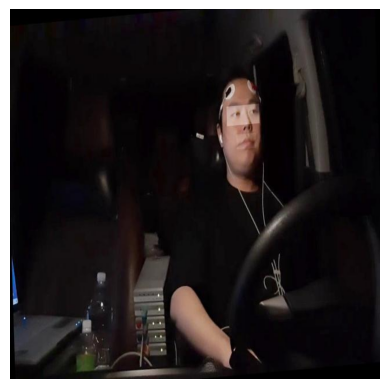

In [32]:
# Path to the predicted image
predicted_image_path = "/kaggle/input/drowsy-detection-dataset/test/images/SGA2101132S0125IMG0005_jpg.rf.bfbeefa7a5f04a2ee3999623d54b035b.jpg"

# Load the predicted image
predicted_image = Image.open(predicted_image_path)

# Display the predicted image using matplotlib
plt.imshow(predicted_image)
plt.axis('off')
plt.show()


# 

In [10]:
!yolo predict task=detect model=/kaggle/working/runs/detect/train/weights/best.onnx imgsz=640 source="/kaggle/input/drowsy-detection-dataset/test/images/SGA2101132S0140IMG0001_jpg.rf.7428a45b04f313d0a121d5f172023909.jpg"

Ultralytics YOLOv8.1.2 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15102MiB)
Loading /kaggle/working/runs/detect/train/weights/best.onnx for ONNX Runtime inference...

image 1/1 /kaggle/input/drowsy-detection-dataset/test/images/SGA2101132S0140IMG0001_jpg.rf.7428a45b04f313d0a121d5f172023909.jpg: 640x640 2 closed_eyes, 1 closed_mouth, 56.5ms
Speed: 14.2ms preprocess, 56.5ms inference, 142.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


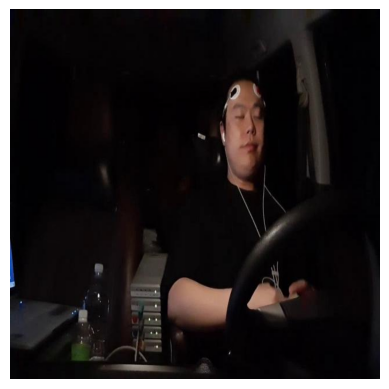

In [13]:
# Path to the predicted image
predicted_image_path = "/kaggle/input/drowsy-detection-dataset/test/images/SGA2101132S0140IMG0001_jpg.rf.7428a45b04f313d0a121d5f172023909.jpg"
# Load the predicted image
predicted_image = Image.open(predicted_image_path)

# Display the predicted image using matplotlib
plt.imshow(predicted_image)
plt.axis('off')
plt.show()

### Training Evaluation Metrics

In [30]:
def display_images(image_paths):
    # Number of rows and columns in the grid
    num_rows = 2
    num_cols = 2

    # Create a subplot with the specified number of rows and columns
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 10))

    # Loop through the image paths and display each image in the grid
    for i, (ax, path) in enumerate(zip(axs.flatten(), image_paths), 1):
        if i <= len(image_paths):
            image = cv2.imread(path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            ax.imshow(image_rgb)
            ax.axis('off')
            ax.set_title(f'Image {i}')
        else:
            ax.axis('off')  # Remove the empty subplot

    # Adjust layout to prevent overlap of subplots
    plt.tight_layout()

    # Use Seaborn to improve the visual style
    sns.set(style="whitegrid")
    plt.show()

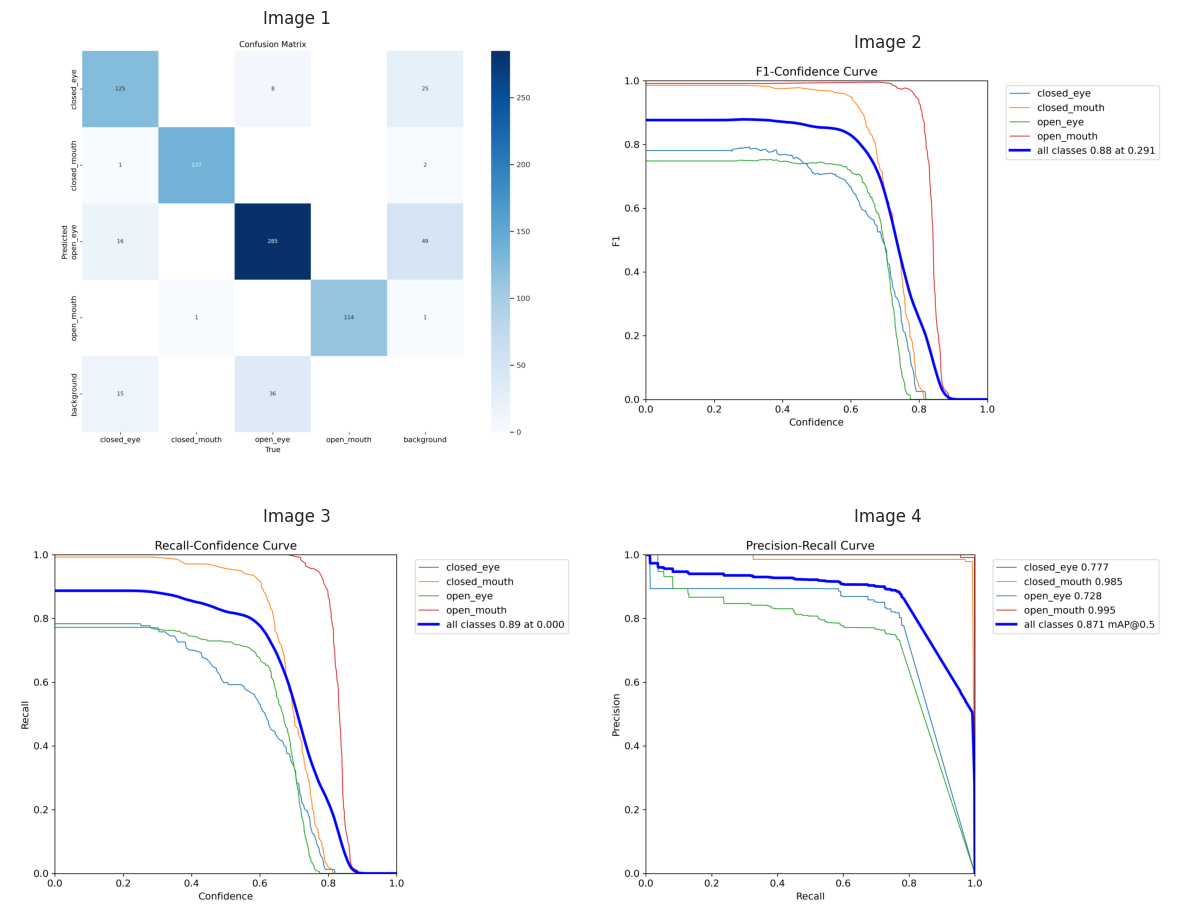

In [31]:
# Replace these with the actual file paths of your images
image_paths = [
    '/kaggle/working/runs/detect/train/confusion_matrix.png',
    '/kaggle/working/runs/detect/train/F1_curve.png',
    '/kaggle/working/runs/detect/train/R_curve.png', 
    '/kaggle/working/runs/detect/train/PR_curve.png', 
]

# Call the function with the image paths
display_images(image_paths)

### Validation Evaluation Metrics

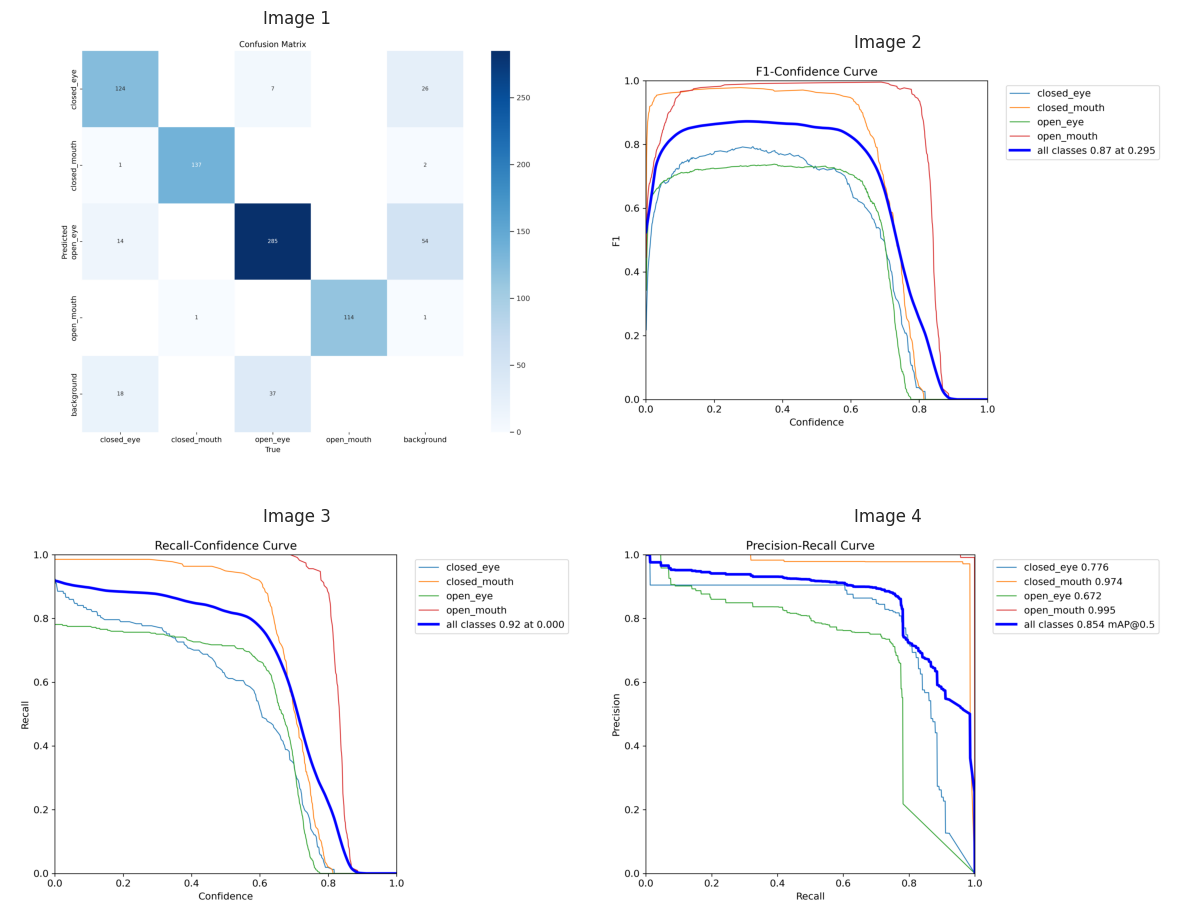

In [32]:
# Replace these with the actual file paths of your images
image_paths = [
    '/kaggle/working/runs/detect/val/confusion_matrix.png',
    '/kaggle/working/runs/detect/val/F1_curve.png',
    '/kaggle/working/runs/detect/val/R_curve.png', 
    '/kaggle/working/runs/detect/val/PR_curve.png', 
]

# Call the function with the image paths
display_images(image_paths)

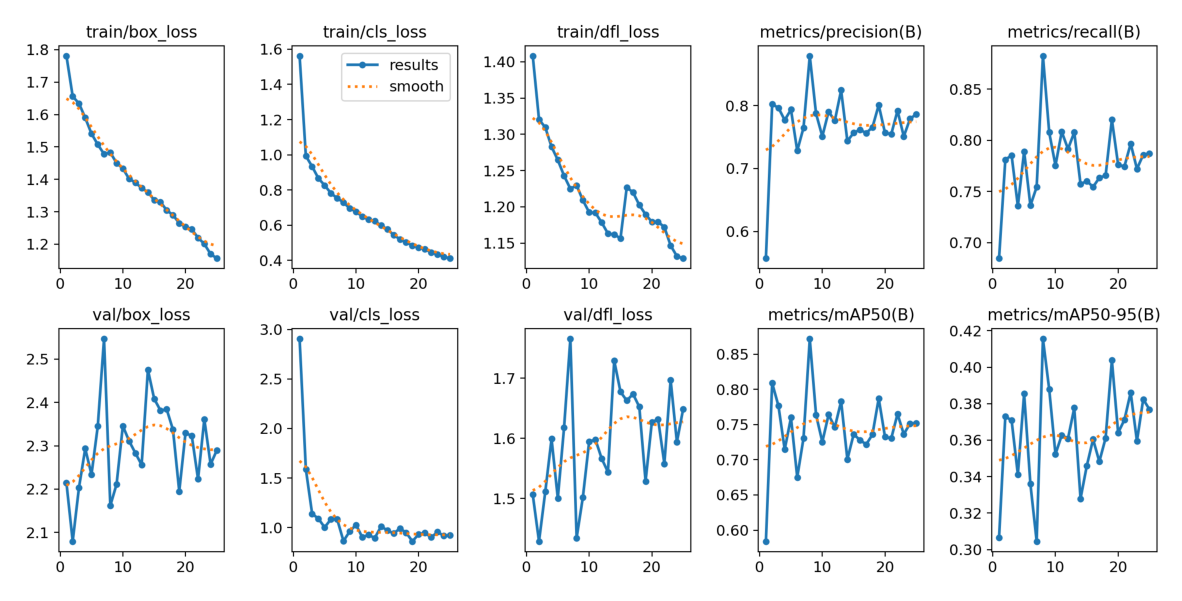

In [33]:
# Replace 'image_filename.jpg' with the actual filename of your image
image_path = '/kaggle/working/runs/detect/train/results.png'

# Create a figure and axis using plt.subplots()
fig, ax = plt.subplots(figsize=(15, 15))

# Load the image using cv2
image = cv2.imread(image_path)

# OpenCV reads images in BGR format, and we need to convert it to RGB for displaying with matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
ax.imshow(image_rgb)
ax.axis('off')  # Optional: Turn off axis labels
plt.show()